# Implémentation : "Object Removal by Exemplar-Based Inpainting"

_Article par : A. Criminisi, P. Pérez K. Toyama_

_Implémentation : Abdennour Kerboua_

## Recueil du contour et calcul de la source et cible

### Importations

In [6]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

### Selection contour

Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.
Contour sélectionné : [(168, 72), (187, 72), (259, 208), (252, 223), (119, 226), (104, 212), (168, 72)]
Pixels du contour : [[ 72 168]
 [ 72 169]
 [ 72 170]
 [ 72 171]
 [ 72 172]
 [ 72 173]
 [ 72 174]
 [ 72 175]
 [ 72 176]
 [ 72 177]
 [ 72 178]
 [ 72 179]
 [ 72 180]
 [ 72 181]
 [ 72 182]
 [ 72 183]
 [ 72 184]
 [ 72 185]
 [ 72 186]
 [ 72 187]
 [ 73 168]
 [ 73 188]
 [ 74 167]
 [ 74 188]
 [ 75 167]
 [ 75 189]
 [ 76 166]
 [ 76 189]
 [ 77 166]
 [ 77 190]
 [ 78 165]
 [ 78 190]
 [ 79 165]
 [ 79 191]
 [ 80 164]
 [ 80 191]
 [ 81 164]
 [ 81 192]
 [ 82 163]
 [ 82 192]
 [ 83 163]
 [ 83 193]
 [ 84 163]
 [ 84 193]
 [ 85 162]
 [ 85 194]
 [ 86 162]
 [ 86 194]
 [ 87 161]
 [ 87 195]
 [ 88 161]
 [ 88 195]
 [ 89 160]
 [ 89 196]
 [ 90 160]
 [ 90 197]
 [ 91 159]
 [ 91 197]
 [ 92 159]
 [ 92 198]
 [ 93 158]
 [ 93 198]
 [ 94 158]
 [ 94 199]
 [ 95 157]
 [ 95 199]
 [ 96 157]
 [ 96 200]
 [ 97 157]
 [ 97 200]
 [ 98 156]
 [ 9

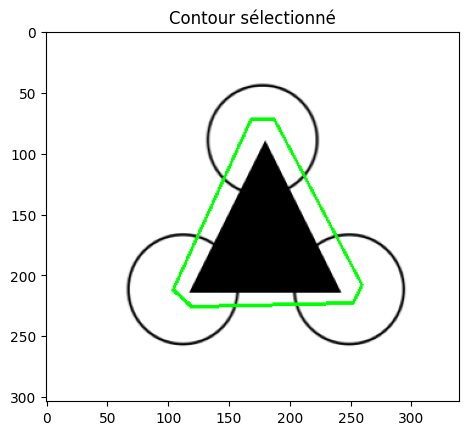

In [50]:
img_path = 'triangle.png'
contour = []

def select_point(event, x, y, flags, param):
    global contour
    if event == cv2.EVENT_LBUTTONDOWN:
        contour.append((x, y))
        cv2.circle(img_copy, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow("Image", img_copy)

def close_contour(contour):
    if contour[0] != contour[-1]:
        contour.append(contour[0])
    return contour

def get_pixels_from_contour(contour):
    mask = np.zeros_like(img_gray)
    cv2.polylines(mask, [np.array(contour)], isClosed=True, color=255, thickness=1)
    pixels = np.column_stack(np.where(mask == 255))
    return pixels

img = cv2.imread(img_path)

if img is None:
    raise ValueError("L'image n'a pas pu être chargée. Assurez-vous que le chemin est correct.")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_copy = img.copy()

cv2.imshow("Image", img_copy)
cv2.setMouseCallback("Image", select_point)

print("Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

if len(contour) >= 3:
    closed_contour = close_contour(contour)
    pixels = get_pixels_from_contour(closed_contour)

    #print("Contour sélectionné :", closed_contour)
    #print("Pixels du contour :", pixels)

    img_with_contour = img.copy()
    cv2.polylines(img_with_contour, [np.array(closed_contour)], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    plt.title('Contour sélectionné')
    plt.show()
else:
    print("Sélection incomplète : au moins 3 points sont nécessaires pour un contour.")

### Calcul de la surface cible et source

<Figure size 640x480 with 0 Axes>

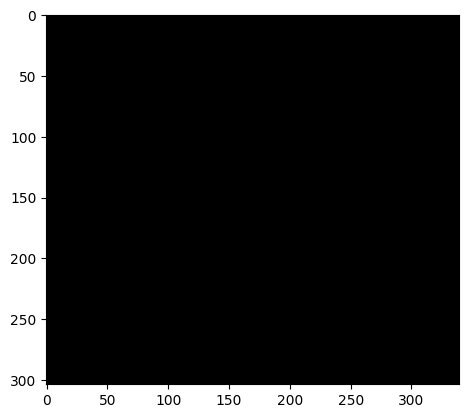

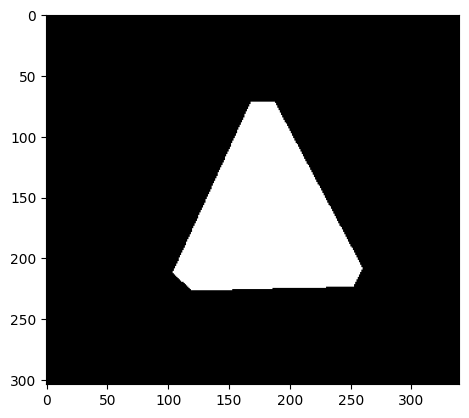

<Figure size 640x480 with 0 Axes>

In [51]:
def find_surface_and_complement(img_shape, contour):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    plt.imshow(mask,cmap="gray")
    cv2.fillPoly(mask, np.array([contour]), 255)
    plt.figure()
    plt.imshow(mask,cmap="gray")
    surface_pixels = np.column_stack(np.where(mask == 255))
    complement_pixels = np.column_stack(np.where(mask == 0))

    return surface_pixels, complement_pixels

pixels_rev=np.array([[pix[1],pix[0]] for pix in pixels])

cible, source = find_surface_and_complement(img.shape,pixels_rev)
img_in_progress = img_gray.copy()
filled = np.zeros(img_in_progress.shape, dtype=bool)
mask = np.zeros(img_in_progress.shape)
for pix in source:
    filled[pix[0],pix[1]]=True
    mask[pix[0],pix[1]]=1
for pix in cible:
    img_in_progress[pix[0],pix[1]] = 0
contour = pixels
data_coeff = {}
plt.figure()

### **1a.** Caclul du front à chaque itération

In [10]:
def calculer_front():
    hauteur, largeur = filled.shape
    contour = []

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for i in range(hauteur):
        for j in range(largeur):
            if filled[i, j] == False:
                for di, dj in directions:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < hauteur and 0 <= nj < largeur:
                        if filled[ni, nj] ==True:
                            contour.append([i,j])
                            break

    return np.array(contour)

### **1b.** Calcul des priorités pour le contour

#### Calcul de la confiance pour un pixel $p$ donné et fonction de mise à jour pour le contour

In [11]:
def init_confidence(source,priority):
    for pix in source:
            priority[pix[0],pix[1]] = 1
    return "Pixel source initialisés à 1"

def maj_confidence_pix(y,x,taille_patch,confidence):
    new_c = 0
    hauteur, largeur = confidence.shape
    tp2 = taille_patch//2
    for xprime in range(max(0,x-tp2),min(largeur,x+tp2+1)):
        for yprime in range(max(y - tp2,0),min(y+tp2+1,hauteur)):
            if mask[yprime,xprime]==1:
                new_c+=confidence[yprime,xprime]
    confidence[y,x] = new_c/(taille_patch**2)
    return

def maj_confidence_contour(contour,taille_patch,confidence):
    for pix in contour:
        y,x = pix[0],pix[1]
        maj_confidence_pix(y,x,taille_patch,confidence)
    return

In [52]:
# Initialisations
taille_patch = 31
confidence = np.zeros(img_gray.shape)
init_confidence(source,confidence)

'Pixel source initialisés à 1'

#### Calcul du data coefficient

In [13]:
def calculer_data(image, pixels):
    image = image.astype(np.int16)
    hauteur, largeur = image.shape
    resultats = {}

    for (y, x) in pixels:
        gradient_x = (image[y, min(x+1, largeur-1)] - image[y, max(x-1, 0)])
        gradient_y = (image[min(y+1, hauteur-1), x] - image[max(y-1, 0), x])

        resultats[(y,x)] = (gradient_x**2 + gradient_y**2)**0.5
        # Ajouter le calcul de la normale (même si cela n'a pas l'air d'influer)
    return resultats

### **2a.** Selection du pixel traité

In [14]:
def get_prior_pixel():
    pix = np.zeros([])
    priomax = float('-inf')
    for pixcand in contour:
        prio_cand = confidence[pixcand[0],pixcand[1]] * data_coeff[(pixcand[0],pixcand[1])]
        if prio_cand >= priomax:
            pix = pixcand
    return pix

### **2b.** Calcul du meilleur patch

In [53]:
def distance(source,x_patch,y_patch,filled,img,mask_cropped):
    tp2 = taille_patch//2
    hauteur,largeur = img.shape
    patch = img[y_patch-tp2:y_patch+tp2+1,x_patch-tp2:x_patch+tp2+1]
    patch = patch.astype(np.int64)
    source = source.astype(np.int64)
    diff = source - patch
    ssd = diff**2
    #for i in range(2*tp2+1):
     #   for j in range(2*tp2+1):
      #      if not filled[i,j]:
       #         ssd[i,j] = 0
    ssd = ssd * mask_cropped
    res = np.sum(ssd)
    return res

In [16]:
def is_in_source(filled_cropped):
    for el in filled_cropped:
        for el2 in el:
            if not el2:
                return False
    return True

In [56]:
def get_best_patch(img,x_patch,y_patch):
    hauteur, largeur = img.shape
    distancemin = float('inf')
    tp2 = taille_patch//2
    x_opt, y_opt = taille_patch, taille_patch
    x_min,x_max = tp2,largeur-tp2
    y_min,y_max = tp2,hauteur-tp2
    filled_cropped_patch = filled[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    mask_cropped = mask[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    for y in range(y_min,y_max):
        for x in range(x_min,x_max):
            source = img[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            filled_cropped = filled[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            if is_in_source(filled_cropped):
                distance_cand = distance(source,x_patch,y_patch,filled_cropped_patch,img,mask_cropped)
                if distance_cand < distancemin:
                    x_opt,y_opt = x,y
                    distancemin = distance_cand
    print(x_opt,y_opt)
    #print(distancemin)
    return x_opt,y_opt

### **2b.** / **3.** Copie du patch et mise a jour des pixels remplis

In [55]:
def copie(x_source,y_source,x_patch,y_patch,img):
    tp2 = taille_patch//2
    nmb = 0
    for i in range(-tp2,tp2+1):
        for j in range(-tp2,tp2+1):
            if (not filled[y_patch+i,x_patch + j]):
                nmb+=1
                img[y_patch + i,x_patch + j] = img[y_source + i,x_source+j]
                confidence[y_patch + i,x_patch +j]=confidence[y_patch,x_patch]
                np.append(source,[y_patch,x_patch])
                filled[y_patch + i,x_patch + j] = True
                mask[y_patch + i,x_patch + j] = 1
    #print("Nombre de pixels copiés",nmb)
    return nmb

## Algorithme final

In [57]:
from tqdm import tqdm
with tqdm(total=cible.shape[0], desc="Traitement des pixels") as pbar:
    while filled[filled==False].shape[0] !=0:
        #t1 = time.time()
        maj_confidence_contour(contour,taille_patch,confidence)
        #print("Après calcul de confidence =",time.time()-t1)
        #t2 = time.time()
        data_coeff = calculer_data(img_gray,contour)
        #print("Après calcul du data =",time.time()-t2)
        #t3 = time.time()
        pix = get_prior_pixel()
        #print("Après calcul du pixel traité =",time.time()-t3)
        #t4 = time.time()
        y_patch,x_patch = pix[0],pix[1]
        x_opt, y_opt=get_best_patch(img_in_progress,x_patch,y_patch)
        #print("Après calcul du meilleur patch =",time.time()-t4)
        #t5 = time.time()
        res = copie(x_opt,y_opt,x_patch,y_patch,img_in_progress)
        pbar.update(res)
        #print("Après copie =",time.time()-t5)
        #t6 = time.time()
        #print("nombre de pixels non-traités :",filled[filled==False].shape[0])
        contour=calculer_front()
        #print("Après calcul du front =",time.time()-t6)

Traitement des pixels:   0%|          | 0/14357 [00:00<?, ?it/s]/var/folders/x3/c14j1vdn7wj4znv2cghvl0cc0000gn/T/ipykernel_2880/3281993804.py:10: RuntimeWarning: overflow encountered in scalar add
  resultats[(y,x)] = (gradient_x**2 + gradient_y**2)**0.5
/var/folders/x3/c14j1vdn7wj4znv2cghvl0cc0000gn/T/ipykernel_2880/3281993804.py:10: RuntimeWarning: invalid value encountered in power
  resultats[(y,x)] = (gradient_x**2 + gradient_y**2)**0.5
Traitement des pixels:   3%|▎         | 492/14357 [00:01<00:51, 268.19it/s]

278 225


Traitement des pixels:   5%|▍         | 705/14357 [00:03<01:18, 173.88it/s]

15 15


Traitement des pixels:   8%|▊         | 1186/14357 [00:05<01:03, 207.33it/s]

15 15


Traitement des pixels:  10%|▉         | 1397/14357 [00:07<01:17, 167.75it/s]

306 224


Traitement des pixels:  13%|█▎        | 1878/14357 [00:09<01:03, 195.36it/s]

227 44


Traitement des pixels:  15%|█▍        | 2089/14357 [00:11<01:14, 164.46it/s]

76 223


Traitement des pixels:  16%|█▌        | 2281/14357 [00:13<01:25, 141.72it/s]

15 15


Traitement des pixels:  17%|█▋        | 2472/14357 [00:15<01:33, 126.69it/s]

15 15


Traitement des pixels:  21%|██        | 2953/14357 [00:17<01:10, 162.37it/s]

290 209


Traitement des pixels:  22%|██▏       | 3182/14357 [00:19<01:15, 147.87it/s]

274 209


Traitement des pixels:  26%|██▌       | 3663/14357 [00:21<01:00, 176.61it/s]

60 208


Traitement des pixels:  27%|██▋       | 3874/14357 [00:23<01:07, 155.22it/s]

15 15


Traitement des pixels:  30%|███       | 4355/14357 [00:25<00:55, 180.52it/s]

15 15


Traitement des pixels:  31%|███▏      | 4491/14357 [00:27<01:07, 146.06it/s]

83 207


Traitement des pixels:  32%|███▏      | 4556/14357 [00:29<01:27, 111.46it/s]

15 15


Traitement des pixels:  34%|███▎      | 4844/14357 [00:31<01:19, 120.21it/s]

15 15


Traitement des pixels:  37%|███▋      | 5325/14357 [00:33<00:58, 154.13it/s]

302 193


Traitement des pixels:  39%|███▊      | 5554/14357 [00:35<01:02, 140.86it/s]

286 193


Traitement des pixels:  42%|████▏     | 6035/14357 [00:37<00:49, 168.28it/s]

67 192


Traitement des pixels:  43%|████▎     | 6171/14357 [00:40<00:59, 136.96it/s]

51 192


Traitement des pixels:  45%|████▌     | 6491/14357 [00:42<00:55, 141.42it/s]

15 15


Traitement des pixels:  46%|████▌     | 6612/14357 [00:44<01:06, 116.09it/s]

89 191


Traitement des pixels:  49%|████▊     | 6971/14357 [00:46<00:55, 132.26it/s]

271 185
82 267


Traitement des pixels:  52%|█████▏    | 7456/14357 [00:50<00:55, 124.03it/s]

15 15


Traitement des pixels:  53%|█████▎    | 7640/14357 [00:52<00:58, 114.66it/s]

293 177


Traitement des pixels:  57%|█████▋    | 8121/14357 [00:54<00:43, 143.55it/s]

73 176


Traitement des pixels:  57%|█████▋    | 8242/14357 [00:57<00:51, 119.72it/s]

57 176


Traitement des pixels:  59%|█████▉    | 8435/14357 [00:59<00:53, 111.11it/s]

106 176


Traitement des pixels:  59%|█████▉    | 8466/14357 [01:01<01:10, 83.72it/s] 

153 54


Traitement des pixels:  61%|██████▏   | 8805/14357 [01:03<00:52, 105.39it/s]

276 169


Traitement des pixels:  65%|██████▍   | 9286/14357 [01:05<00:36, 140.21it/s]

15 15


Traitement des pixels:  66%|██████▌   | 9479/14357 [01:07<00:38, 125.22it/s]

15 15


Traitement des pixels:  69%|██████▉   | 9960/14357 [01:09<00:28, 154.09it/s]

73 160


Traitement des pixels:  70%|██████▉   | 9991/14357 [01:12<00:38, 112.51it/s]

15 15


Traitement des pixels:  70%|███████   | 10072/14357 [01:14<00:47, 90.04it/s]

97 160


Traitement des pixels:  73%|███████▎  | 10409/14357 [01:16<00:36, 109.36it/s]

15 15


Traitement des pixels:  76%|███████▌  | 10890/14357 [01:18<00:24, 142.22it/s]

15 15


Traitement des pixels:  77%|███████▋  | 11011/14357 [01:20<00:28, 115.98it/s]

15 15


Traitement des pixels:  79%|███████▉  | 11318/14357 [01:23<00:24, 122.97it/s]

15 15


Traitement des pixels:  80%|███████▉  | 11469/14357 [01:25<00:27, 106.40it/s]

15 15


Traitement des pixels:  81%|████████▏ | 11689/14357 [01:27<00:25, 104.08it/s]

225 266


Traitement des pixels:  85%|████████▍ | 12170/14357 [01:29<00:15, 137.57it/s]

15 15


Traitement des pixels:  86%|████████▌ | 12363/14357 [01:31<00:16, 122.05it/s]

238 99


Traitement des pixels:  87%|████████▋ | 12558/14357 [01:34<00:16, 111.42it/s]

287 253


Traitement des pixels:  89%|████████▉ | 12788/14357 [01:36<00:14, 108.22it/s]

230 249


Traitement des pixels:  91%|█████████▏| 13104/14357 [01:38<00:10, 117.38it/s]

272 237


Traitement des pixels:  93%|█████████▎| 13360/14357 [01:41<00:08, 115.76it/s]

15 15


Traitement des pixels:  96%|█████████▌| 13712/14357 [01:43<00:05, 126.92it/s]

196 28
225 229


Traitement des pixels:  97%|█████████▋| 13903/14357 [01:48<00:05, 86.99it/s] 

136 220


Traitement des pixels:  98%|█████████▊| 14024/14357 [01:50<00:04, 77.56it/s]

15 15


Traitement des pixels:  99%|█████████▉| 14260/14357 [01:52<00:01, 82.79it/s]

15 15


Traitement des pixels: 100%|█████████▉| 14339/14357 [01:55<00:00, 68.99it/s]

15 15


Traitement des pixels: 100%|██████████| 14357/14357 [01:57<00:00, 121.99it/s]

15 15


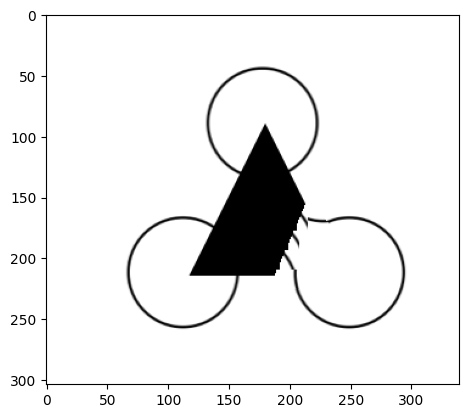

In [49]:
cv2.imwrite("image_res_triangle.png",img_in_progress)
plt.imshow(img_in_progress,cmap="gray")

[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1.]]
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True]
 [ True  True  True False False False  True  True  True]
 [ True  True  True False False False  True  True  True]
 [ True  True False False False False False  True  True]
 [ True  True False False False False False  True  True]]


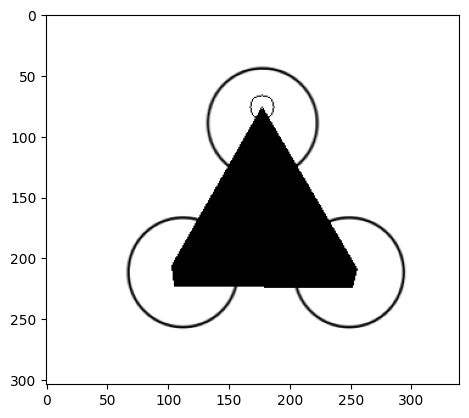

In [38]:
tp2 = taille_patch//2
y_patch,x_patch = contour[0]
cv2.circle(img_in_progress,(x_patch,y_patch),radius=10,color=0)
plt.imshow(img_in_progress,cmap='gray')
print(mask[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1])
print(filled[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1])